In [2]:
# CIFAR-10有10个类别，每张图片3×32×32，即3通道彩色图片，分辨率为32×32

In [3]:
# ------------------数据加载及预处理-----------------------

In [4]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

In [5]:
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [6]:
# 第一次运行torchvision时会自动下载CIFAR-10数据集（因为download参数设置为True）
# 若之前已下载，可通过root参数指定

In [7]:
# 定义对数据的预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
])

In [8]:
# 训练集
# 第一次运行torchvision时会自动下载CIFAR-10数据集（因为download参数设置为True）
# 若之前已下载，可通过root参数指定
trainset = tv.datasets.CIFAR10(
                    root='data/',
                    train=True,
                    download=True,
                    transform=transform)

Files already downloaded and verified


In [9]:
import torch as t
trainloader = t.utils.data.DataLoader(
                    trainset,
                    batch_size=4,
                    shuffle=True,
                    num_workers=2)

In [10]:
# 测试集
testset = tv.datasets.CIFAR10(
                    'data/',
                    train=False,
                    download=True,
                    transform=transform)

Files already downloaded and verified


In [11]:
testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4,
                    shuffle=False,
                    num_workers=2)

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

ship


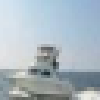

In [13]:
# Dataset 对象是一个数据集，可以按下标访问
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

       ship        ship        frog        bird


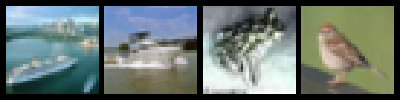

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [15]:
# ------------------定义网络-----------------------

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [18]:
# ------------------定义损失函数和优化器-----------------------

In [19]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
# ------------------训练网络-----------------------
# 所有网络的训练流程都是类似的：
# 输入数据 -> 前向传播+反向传播 -> 更新参数

In [21]:
from torch.autograd import Variable
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 输入数据
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播+反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # 更新参数
        optimizer.step()
        # 打印log信息
        running_loss += loss.data[0]
        if i % 2000 == 1999: # 每2000个batch打印一个训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
    print('Finished Training')

[1,  2000] loss: 2.192
[1,  4000] loss: 1.872
[1,  6000] loss: 1.689
[1,  8000] loss: 1.589
[1, 10000] loss: 1.491
[1, 12000] loss: 1.440
Finished Training
[2,  2000] loss: 1.357
[2,  4000] loss: 1.330
[2,  6000] loss: 1.312
[2,  8000] loss: 1.308
[2, 10000] loss: 1.257
[2, 12000] loss: 1.251
Finished Training


In [22]:
# 此处仅训练了2个epoch（遍历完一遍数据集称为一个epoch）
# 将测试图片输入网络，计算它的label，然后与实际的label进行比较

('\xe5\xae\x9e\xe9\x99\x85\xe7\x9a\x84label\xef\xbc\x9a', '     cat     ship     ship    plane')


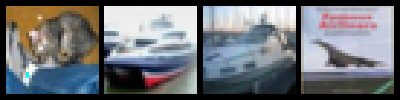

In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label：', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [24]:
# 接着计算网络预测的label

In [57]:
# 计算图片在每个类别上的分数
outputs = net(Variable(images))
#print(outputs.data)

# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)
#print(predicted)

print('预测结果：', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

# 最后的print语句在我的电脑上运行出错，大概是因为 predicted[j] 是LongTensor类型
# 而不是所要求的int类型。我尝试使用.numpy()和astype(int)来转换都不行
# 问题尚待解决

TypeError: tuple indices must be integers, not torch.LongTensor

In [58]:
# 看看在整个测试集上的效果

In [59]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = t.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('10000张测试集中的准确率为：%d %%' % (100 * correct / total))

10000张测试集中的准确率为：55 %


In [60]:
# 训练的准确率远比随机猜测（准确率为10%）的效果好，证明网络确实学到东西

In [61]:
if t.cuda.is_available():
    net.cuda()
    images = images.cuda()
    labels = labels.cuda()
    output = net(Variable(images))
    loss = criterion(output, Variable(labels))